# Experimentation on using Fast / Slow learning updates and life-long-learning as a method of long term memory.

The idea here is that the weights of a neural network represent some kind of memory of the agents previous experience.  By using two networks, one with slow updates and one with fast updates we gain the ability to retain longterm information aswell as respond to short term changes.

**Model Architecture**
* todo...

**Experiments**
* Maze4x4
* T-Maze
* Random NxN partial information mazes

**Notes**
The fast and slow parts require backprop during *testing* aswell as training.  The muxer, however should be froozen.

In [179]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [180]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms

from agents.agent import RandomAgent, Agent
from utils.rl import evaluate_agent, plot_reward_history, show_moves
from env.environments import TMaze
from utils.utils import softmax

import matplotlib.pyplot as plt
import numpy as np

# 1. Setup our model

In [181]:
# global parameters
USE_CUDA = False
BATCH_SIZE = 32

ALPHA = 0.1
GAMMA = 0.99

In [182]:

# the training loop
def train(model, env, device, train_loader, optimizer, epoch, verbose=True):
    model.train()
    for i, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if verbose and i % 250 == 0:
            print("Train Epoch: {} [{:.0f}%]\tLoss: {:.6f}".format(
                epoch, 100 * i / len(train_loader), loss.item()))            
            


## 2. Experiments

### 2.1 4x4 Maze with complete information

This is just to make sure the algorithm is working...

### 2.2 4x4 Maze with no Observation

A 4x4 maze where agent is given no useful observations.

### 2.3 T-Maze

T-Maze demonistrates the agents ability to retain important information at the start of an episode and apply it later on.

LSTM units typically get ~70 steps on this task. See this [paper](https://papers.nips.cc/paper/1953-reinforcement-learning-with-long-short-term-memory.pdf).

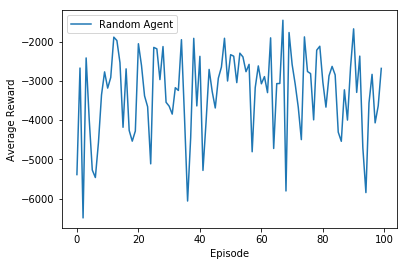

In [5]:
def plot_agent_history(agent, env):
    
    steps = 1000
    episodes = 100
    trials = 30
    
    total_reward = np.zeros(episodes)

    for j in range(trials):
        for i in range(episodes):
            total_reward[i] += np.array(np.sum(evaluate_agent(agent, env, steps))) / trials

    plt.plot(range(episodes), total_reward, label=agent)        
    plt.xlabel("Episode")
    plt.ylabel("Average Reward")    
    plt.legend()
    plt.show()

# setup the game
env = TMaze()
agent = RandomAgent(env.action_space)

evaluate_agent(agent, env)
plot_agent_history(agent,env)

In [183]:
# LSTM Agent

# todo: code this up.
class LSTMAgent(Agent):
    """ LSTM agent has two LSTM units that it can use to make """
    
    def __init__(self, action_space):
        super().__init__("LSTM Agent")
        self.action_space = action_space

    def act(self, observation, reward):
        pass    

In [196]:
# Our Fast / Slow model
class FastSlowNet(nn.Module):
    
    def __init__(self, input_dims, output_dims):
        super().__init__()
        
        internal_dims = 16
        
        self.mux1 = nn.Linear(internal_dims*2, internal_dims)
        self.mux2 = nn.Linear(internal_dims, output_dims)
        
        self.fast1 = nn.Linear(input_dims, internal_dims)
        self.fast2 = nn.Linear(internal_dims, internal_dims)
        
        self.slow1 = nn.Linear(input_dims, internal_dims)
        self.slow2 = nn.Linear(internal_dims, internal_dims)
        
        self.V_map = nn.Linear(internal_dims, 1)
        self.Q_map = nn.Linear(internal_dims, output_dims)
        
    def fast_part(self, x):
        x = F.relu(self.fast1(x))
        x = F.relu(self.fast2(x))
        return x        
    
    def slow_part(self, x):
        x = F.relu(self.slow1(x))
        x = F.relu(self.slow2(x))
        return x        
    
    def muxer(self, slow, fast):
        """ Combine fast and slow part """
        x = torch.cat((fast, slow), dim=0)
        x = F.relu(self.mux1(x))
        x = self.mux2(x)
        return F.softmax(x, dim=0)  
    
    def V(self, x):
        """ For actor critic we generate V values.
            Input is observation, output is V values for this state
        """
        slow = self.slow_part(x)
        fast = self.fast_part(x)
        x = torch.cat((fast, slow), dim=0)
        x = F.relu(self.mux1(x))
        x = self.V_map(x)
        return x 
    
    def Q(self, x):
        """ For actor critic we generate Q values.
            Input is observation, output is Q values for each action from this state.
        """
        slow = self.slow_part(x)
        fast = self.fast_part(x)
        x = torch.cat((fast, slow), dim=0)
        x = F.relu(self.mux1(x))
        x = self.Q_map(x)
        return x 
    
    def forward(self, x):
        """ Run input through network. """ 
        slow = self.slow_part(x)
        fast = self.fast_part(x)
        return self.muxer(slow, fast)
        
# policy update algorithm.
class FastSlowAgent(Agent):
    
    def __init__(self, obs_dims, actions):
        super().__init__("Fast Slow Agent")
        self.network = FastSlowNet(input_dims=obs_dims, output_dims=actions)
        self.network.to('cpu')
        
        slow_rate = 0.001
        normal_rate = 0.001
        fast_rate = 0.001
        
        # custom learning rates for the network.
        """
        self.optimizer = optim.SGD(
        [
            {"params": self.network.fast1.parameters(), "lr": fast_rate},
            {"params": self.network.fast2.parameters(), "lr": fast_rate},                            
            {"params": self.network.slow1.parameters(), "lr": slow_rate},
            {"params": self.network.slow2.parameters(), "lr": slow_rate},                            
        ],
        lr=normal_rate,
        )  """
        self.optimizer = optim.SGD(self.network.parameters(), lr=0.001)
        
    def act(self, observation):
        return self.sample_action(self.probs(observation))
        
    def sample_action(self, probs):
        probs = np.asarray(probs.tolist())
        
        # for some reason probs end up being 1.000000059, so we fix them here.
        norm = sum(probs)    
        if norm != 0:
            probs = probs / norm  
        
        # sample action        
        action = int(np.random.choice(range(len(probs)), p=probs))
        
        return action
    
    def probs(self, observation):
        """ Returns policy probabilities"""    
        observation = torch.FloatTensor(observation).to('cpu')
        probs = self.network(observation)
        return probs
    
    def Q(self, observation):
        """ Returns Q values for given state. """
        observation = torch.FloatTensor(observation).to('cpu')
        return self.network.Q(observation)
    
    def V(self, observation):
        """ Returns V value for given state. """
        observation = torch.FloatTensor(observation).to('cpu')
        return self.network.V(observation)
            
def smooth(X):
    y = X[0]
    Y = []
    for x in X:
        y = 0.9*y + 0.1*x
        Y.append(y)
    return Y
        
def nice_print(X):
    print([round(float(x),4) for x in X])

def print_tmaze_policy(agent):
    """Prints agents policy on T-Maze. """
    print("start    ",end='',) 
    nice_print(agent.probs((1,1,0)))
    print("         ",end='',) 
    nice_print(agent.probs((0,1,1)))            
    print("end      ",end='',) 
    nice_print(agent.probs((0,1,0)))
    print("corridor ",end='',) 
    nice_print(agent.probs((1,0,1)))
    
    

In [203]:
# first we run an episode on the current policy.
env = TMaze(4)
agent = FastSlowAgent(obs_dims = 3, actions=4)
print_tmaze_policy(agent)

steps_taken = []
total_reward = []
final_reward = []

def train_tmaze():
    for episode in range(1000):
        observation = env.reset()
        reward = 0
        done = False
        action = agent.act(observation)

        R = 0

        for t in range(100):

            next_observation, reward, done, info = env.step(action)
            next_action = agent.act(next_observation)

            policy = agent.probs(observation)            
            log_policy = torch.log(policy[action])

            Q_value = agent.Q(observation)[action]    

            td = reward + GAMMA * agent.Q(next_observation)[next_action] - Q_value

            policy_loss = -(ALPHA * td.detach() * log_policy)

            critic_loss = td.pow(2)

            agent.optimizer.zero_grad()
            loss = (policy_loss + critic_loss)
            loss.backward()
            agent.optimizer.step()

            observation = next_observation
            action = next_action

            R += reward

            if episode % 100 == 1 and t == 0:
                print("Initial Q value: {:2f} EMA reward: {:.2f}".format(float(Q_value), smooth(total_reward)[-1]))

            if done:
                break       

        steps_taken.append(t)
        total_reward.append(R)
        final_reward.append(reward)

ALPHA = 10
GAMMA = 0.99
train_tmaze()

start    [0.2811, 0.226, 0.2589, 0.234]
         [0.2681, 0.2234, 0.276, 0.2324]
end      [0.2721, 0.2219, 0.2735, 0.2324]
corridor [0.269, 0.2262, 0.2688, 0.236]
Initial Q value: 0.199099 EMA reward: -10.00
Initial Q value: 0.001809 EMA reward: 0.00
Initial Q value: 0.026557 EMA reward: -0.86
Initial Q value: -0.008443 EMA reward: -0.81
Initial Q value: -0.036964 EMA reward: -1.40
Initial Q value: -0.068677 EMA reward: -0.80
Initial Q value: -0.057660 EMA reward: 1.37
Initial Q value: -0.471512 EMA reward: 2.05
Initial Q value: -0.445269 EMA reward: 1.67
Initial Q value: -0.316488 EMA reward: 1.93


Current Policy
start    [0.0072, 0.6737, 0.0546, 0.2646]
         [0.0097, 0.6209, 0.0759, 0.2935]
end      [0.0018, 0.0444, 0.0803, 0.8734]
corridor [0.0097, 0.842, 0.0393, 0.1091]
Agent picked correct door 54.40% of the time.


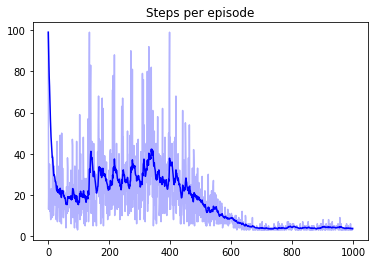

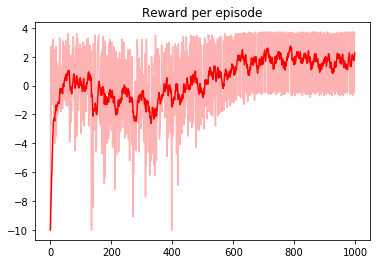

In [204]:
print("Current Policy")
print_tmaze_policy(agent)

last_half = np.asarray(final_reward)
last_half = last_half[len(last_half)//2:]
print("Agent picked correct door {:.2f}% of the time.".format(100*np.mean(last_half==4)))

plt.plot(range(len(steps_taken)), steps_taken, color='blue', alpha=0.3)
plt.plot(range(len(steps_taken)), smooth(steps_taken), color='blue')
plt.title("Steps per episode")
plt.show()

plt.plot(range(len(total_reward)), total_reward, color='red', alpha=0.3)
plt.plot(range(len(total_reward)), smooth(total_reward), color='red')
plt.title("Reward per episode")
plt.show()


Optimial on this problem is an average of 3.6, without memory the best that can be achived is ~1.6.

In [167]:
# step through the agents actions
observation = env.reset()
reward = 0
done = False
action = agent.act(observation)
    
R = 0

for t in range(100):
    probs = agent.probs(observation)
    q = agent.Q(observation)
    print("Step {:<4} Observation {} action {}\t total reward {:.2f}".format(t, observation, env.ACTION_NAME[action], R))
    nice_print(q)
    observation, reward, done, info = env.step(action)
    action = agent.act(observation)    
    R += reward
    if done:
        break

Step 0    Observation (1, 1, 0) action up	 total reward 0.00
[-0.5591, -0.4474, -0.4809, -0.4317]
Step 1    Observation (1, 0, 1) action left	 total reward -0.10
[-0.5437, -0.3443, -0.6655, -0.7673]
Step 2    Observation (1, 0, 1) action up	 total reward -0.20
[-0.5437, -0.3443, -0.6655, -0.7673]
Step 3    Observation (1, 0, 1) action up	 total reward -0.30
[-0.5437, -0.3443, -0.6655, -0.7673]
Step 4    Observation (0, 1, 0) action right	 total reward -0.40
[-0.4038, -0.6294, 0.3819, 0.3114]


# Cart pole
just to make sure agent is learning

In [129]:
import gym

def print_cart_policy(agent):
    """Prints agents policy on T-Maze. """
    nice_print(agent.probs((0,0,0,0)))    

env = gym.make("CartPole-v1")

agent = FastSlowAgent(obs_dims=4, actions=2)
print_cart_policy(agent)

steps_taken = []
total_reward = []

def train():
    for episode in range(20000):
        observation = env.reset()
        reward = 0
        action = agent.act(observation)

        R = 0

        for t in range(100):

            # this is the actor critic algorithm described
            # here: https://lilianweng.github.io/lil-log/2018/04/08/policy-gradient-algorithms.html#td3

            next_observation, reward, done, info = env.step(action)
            next_action = agent.act(next_observation)

            # get policy probabilities                                    
            policy = agent.probs(observation)            
            log_policy = torch.log(policy[action])

            # find Q value for given action
            Q_value = agent.Q(observation)[action]    

            # find TD error
            td = reward + GAMMA * agent.Q(next_observation)[next_action] - Q_value

            # update our policy parameters via a loss function
            # the website says to use Q, but I'm using TD, TD ends up being a proxy for
            # the advantage function which better.
            policy_loss = -(ALPHA * td.detach() * log_policy)
            
            # according to the algorithm I should have different weights 
            # for this part, but I'm mostly just sharing the weights used
            # for policy.        
            
            #critic_loss = ALPHA * td.detach() * Q_value
            
            # for some reason the above did not work, so I'm just using td^2 as the loss
            critic_loss = td.pow(2)
            
            
            agent.optimizer.zero_grad()
            loss = (policy_loss + critic_loss)
            loss.backward()
            agent.optimizer.step()
                                    
            observation = next_observation
            action = next_action

            R += reward
            
            if episode % 100 == 1 and t == 0:
                print("Initial Q value: {:2f} EMA reward: {:.2f}".format(Q_value, smooth(total_reward)[-1]))

            if done:
                break  
                            
        steps_taken.append(t)
        total_reward.append(R)

ALPHA = 10

train()

[0.5445, 0.4555]
Initial Q value: 0.061311 EMA reward: 23.00
Initial Q value: -0.110107 EMA reward: 13.98
Initial Q value: -0.076238 EMA reward: 13.20
Initial Q value: -0.060861 EMA reward: 13.42
Initial Q value: 0.000602 EMA reward: 22.13
Initial Q value: 0.000513 EMA reward: 15.89
Initial Q value: 0.037244 EMA reward: 23.40
Initial Q value: 0.071937 EMA reward: 25.43
Initial Q value: 0.127860 EMA reward: 16.89
Initial Q value: 0.112035 EMA reward: 21.51
Initial Q value: 0.165770 EMA reward: 21.97
Initial Q value: 0.163933 EMA reward: 16.84
Initial Q value: 0.205671 EMA reward: 22.89
Initial Q value: 0.236186 EMA reward: 20.74
Initial Q value: 0.259191 EMA reward: 18.92
Initial Q value: 0.273700 EMA reward: 17.48
Initial Q value: 0.316402 EMA reward: 14.76
Initial Q value: 0.335703 EMA reward: 16.64
Initial Q value: 0.352769 EMA reward: 21.52
Initial Q value: 0.359034 EMA reward: 17.41
Initial Q value: 0.370725 EMA reward: 15.72
Initial Q value: 0.420995 EMA reward: 24.94
Initial Q va

KeyboardInterrupt: 

Current Policy
[0.1356, 0.8644]


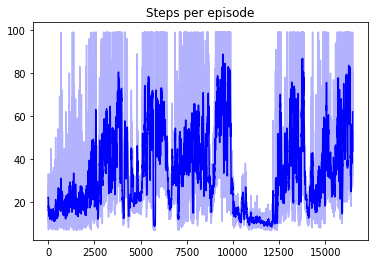

In [134]:
print("Current Policy")
print_cart_policy(agent)

plt.plot(range(len(steps_taken)), steps_taken, alpha=0.3, color='blue')
plt.plot(range(len(steps_taken)), smooth(steps_taken), color='blue')
plt.title("Steps per episode")
plt.show()

In [ ]:
"""
# perform policy update on given model.
# we simply find the advantage, and use that for our loss function.
    
# Compute Values and Probability Distribution
values, prob = self.ac_net(obs_tensor)

# Compute Policy Gradient (Log probability x Action value)
advantages = return_tensor - values
action_log_probs = prob.log().gather(1, action_tensor)
actor_loss = -(advantages.detach() * action_log_probs).mean()

# Compute L2 loss for values
critic_loss = advantages.pow(2).mean()

# Backward Pass
loss = actor_loss + critic_loss
loss.backward()
"""